In [ ]:
##Author: Kushin Mukherjee

I recommend running this notebook inside a conda environment to keep things organized and for reproducibility.

Download and install conda: https://docs.conda.io/projects/conda/en/latest/user-guide/install/  
Creating an environment: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html

Some tips for installing packages:
First, activate your environment then install pip within the environment so that all the packages you install don't get installed to your global path. To do so:  
Type `conda install pip` in your terminal

Then, when in the project directory:  
Type `pip install -r requirements.txt`


We're using python 3 plus the latest versions of all the packages listed below. Be sure to update before running this nb

In [64]:
### import packages

import sys
import random
from importlib import reload
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from IPython.display import clear_output
import svgpathtools
import os.path
from collections import Counter
import svg_rendering_helpers as srh



from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:

# directory & file hierarchy
proj_dir = os.path.abspath('..')
code_dir = os.getcwd()
plot_dir = os.path.join(proj_dir,'plots')
data_dir = os.path.join(proj_dir,'data')


if not os.path.exists(code_dir):
    os.makedirs(code_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# if svg_rendering_helpers.py not in sys.path:
#     sys.path.append(os.path.join(proj_dir,svg_rendering_helpers.py)) 

In [3]:
D = pd.read_csv(os.path.join(data_dir,'semantic_parts_annotated_data.csv'))

In [4]:
def listify(string):
    split_list = string.split("'")
    l=[", u","[u","]"]
    out = [x for x in split_list if x not in l]
    return(out)
    

In [5]:
D.sketch_svg_string = D.sketch_svg_string.apply(listify)
len(D.sketch_svg_string[0])

8

In [6]:
unique_cats = np.unique(D.category)
unique_cats

array(['bird', 'car', 'chair', 'dog'], dtype=object)

In [7]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline
spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


### Generating data for triplets task


In [8]:
## We need to exclude some "bad sketches", which are mostly just handwritten text instead of drawingss

bad_sketches = [
'3058-fb4fe740-d862-453b-a08f-44375a040165_21',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_8',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_12',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_23',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_24',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_15',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_24',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_16',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_20',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_22',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_7',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_13',
'6311-cd21a68a-f1df-4290-b744-b0c7c7c60ed8_5',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_32'
]

stroke_df = stroke_df[~stroke_df['sketch_id'].isin(bad_sketches)]

In [9]:
### Currently constrained by minimum number of sketches in a conditionXcategoryXexemplar cell, which is 4
### We have 2*4*8*4 (256) sketches in total

random.seed(1022)
sample_sketches= []

for this_cat in unique_cats:
    cat_df = stroke_df[stroke_df['category']== this_cat]
    unique_items = np.unique(cat_df['target'])
    for this_item in unique_items:
        item_df = cat_df[cat_df['target']==this_item]
        unique_conds = np.unique(item_df['condition'])
        for this_cond in unique_conds:
            cond_df = item_df[item_df['condition']==this_cond]
            us = np.unique(cond_df['sketch_id']) ## unique sketches in cell
            if len(us)<4:
                print("not enough in cell", this_item, this_cond,len(us))
                break
            rand_sl = np.random.choice(us,size = 4,replace=False) ## list of random sketch ids
            sample_sketches.append(rand_sl)
            

sample_sketches = [y for x in sample_sketches for y in x] ##flatten list
            
assert(len(np.unique(sample_sketches))==len(sample_sketches))
    

In [29]:
render_df = stroke_df[stroke_df['sketch_id'].isin(sample_sketches) ]

In [ ]:
render_df.sketch_id.nunique()

In [ ]:
###Clear directories

svg_dir = os.path.join(plot_dir,'triplet_sketches')
png_dir =  os.path.join(plot_dir,'triplet_sketches_png')
for this_dir in [svg_dir,png_dir]:
    filelist = [ f for f in os.listdir(this_dir) ]
    for this_sketch in filelist:
        file_path = os.path.join(this_dir, this_sketch)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [ ]:
###Render out SVGs and PNGs

reload(srh)
really_run = True

if really_run==True:

    for sketch in render_df.sketch_id.unique():
        this_sketch = render_df.query('sketch_id == @sketch')
        svgs = list(this_sketch.svg)
        srh.render_svg(svgs,out_dir ="triplet_sketches", base_dir=plot_dir,out_fname='{}.svg'.format(sketch))
### Create path to svgs and convert to png for feature extraction
really_run = True

if really_run==True:
    svg_paths= srh.generate_svg_path_list(os.path.join(plot_dir,'triplet_sketches'))
    srh.svg_to_png(svg_paths,out_dir="triplet_sketches_png",base_dir=plot_dir)



In [30]:
render_df_meta = pd.DataFrame(render_df.groupby(['sketch_id','category','target','label']).agg(num_strokes=pd.NamedAgg(column='stroke_id', aggfunc=lambda x: len(x.unique()))))
render_df_meta=render_df_meta.reset_index()
render_df_meta

,sketch_id,category,target,label,num_strokes
0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,armrest,1
1,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,backrest,8
2,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,leg,3
3,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,seat,2
4,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_20,dog,basset,body,2
...,...,...,...,...,...
1063,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_25,chair,woven,leg,2
1064,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_30,dog,bullmastiff,body,1
1065,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_30,dog,bullmastiff,ear,1
1066,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_30,dog,bullmastiff,eye,1


In [ ]:
render_df_meta.to_csv(index=False,path_or_buf=os.path.join(data_dir,'render_meta_data.csv'))

## Two feature analyses using VGG features extraced from UW (Tim + Pablo) feature extractor and Judy's feature extractor

### Judy's extractor

In [67]:
feats = pd.DataFrame(np.load(os.path.join(data_dir,'features/FEATURES_FC6_triplet_sketches.npy')))
feats_meta = pd.read_csv(os.path.join(data_dir,'features/METADATA_triplet_sketches.csv'))

In [68]:
feats_df1 = pd.concat([feats_meta,feats], axis = 1)
render_df_meta = pd.read_csv(os.path.join(data_dir,'render_meta_data.csv'))

In [69]:
_meta_df1 = pd.DataFrame(render_df_meta.groupby(['sketch_id','category','target']).agg(dummy=pd.NamedAgg(column='num_strokes', aggfunc='max')))
_meta_df1=_meta_df1.reset_index()

In [87]:
_meta_df1

,sketch_id,category,target,dummy
0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,8
1,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_20,dog,basset,3
2,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_28,chair,straight,5
3,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_6,dog,pug,5
4,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_16,car,white,3
...,...,...,...,...
251,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_15,bird,cuckoo,3
252,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_17,bird,tomtit,6
253,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_18,dog,doberman,2
254,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_19,chair,straight,8


In [70]:
feats_df1
feats_df1 = feats_df1.join(_meta_df1.set_index('sketch_id'), on = 'sketch_id')
feats_df1.drop(columns=['dummy'])



range(0, 4095)

In [77]:
feat_cols = np.arange(0,4095).tolist()

## PCA

In [65]:
pca = PCA(n_components=3)

In [78]:
pca_result = pca.fit_transform(feats_df1[feat_cols].values)


In [79]:
feats_df1['pca-one'] = pca_result[:,0]
feats_df1['pca-two'] = pca_result[:,1] 
feats_df1['pca-three'] = pca_result[:,2]

In [80]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.0778489  0.06451253 0.04495867]


Text(0.5, 1.0, 'PCA visualization')

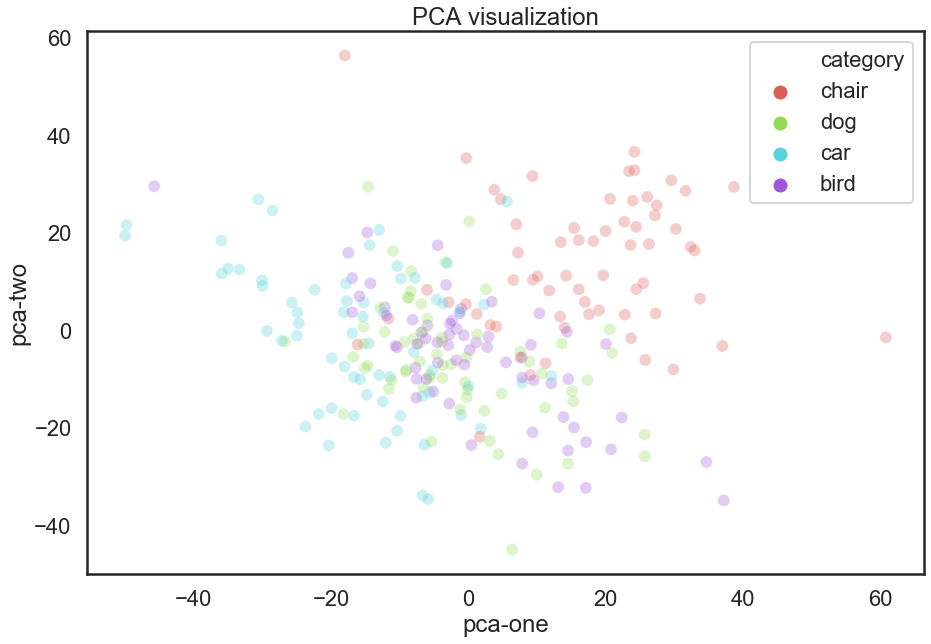

In [127]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=feats_df1,
    legend="full",
    alpha=0.3
).set_title('PCA visualization')

In [90]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats_df1[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.090s...
[t-SNE] Computed neighbors for 256 samples in 0.932s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 19.011858
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.968590
[t-SNE] KL divergence after 300 iterations: 1.291386
t-SNE done! Time elapsed: 2.261559009552002 seconds


Text(0.5, 1.0, 't-SNE visualization')

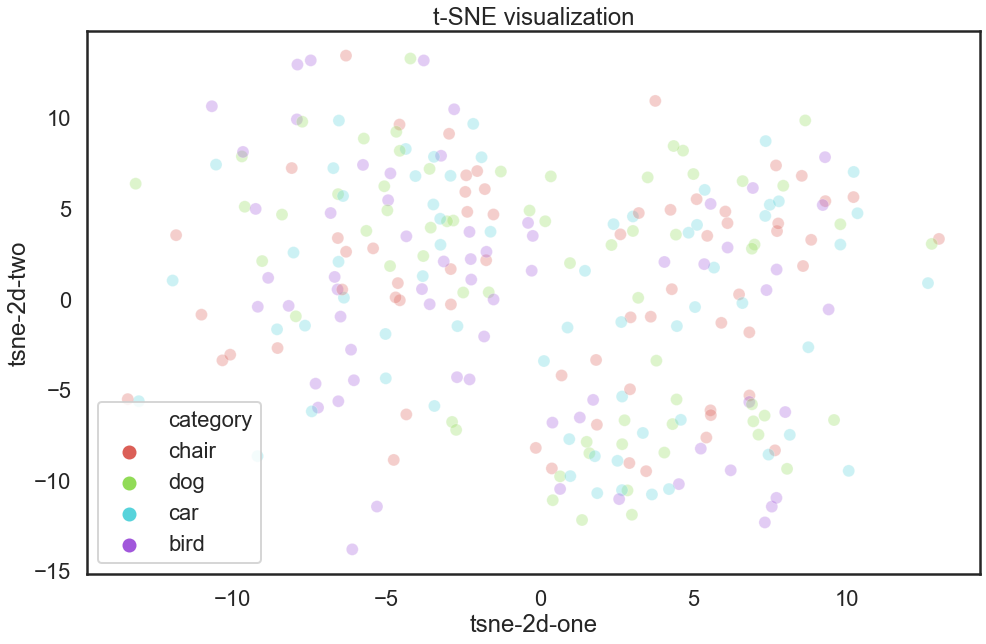

In [128]:
feats_df1['tsne-2d-one'] = tsne_results[:,0]
feats_df1['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=feats_df1,
    legend="full",
    alpha=0.3
).set_title('t-SNE visualization')

### Time and Pablo's extractor

In [104]:
feats2= pd.read_csv(os.path.join(data_dir,'vgg19_fc2_triplet_sketch_features.csv'), header = None)

In [105]:
feat_cols2 = feats2.columns
feat_cols2=feat_cols2.to_list()

In [111]:

feats_df2 = pd.concat([_meta_df1,feats2],axis=1)
feats_df2 = feats_df2.drop(columns=['dummy'])


In [112]:
pca_result = pca.fit_transform(feats_df2[feat_cols].values)
feats_df2['pca-one'] = pca_result[:,0]
feats_df2['pca-two'] = pca_result[:,1] 
feats_df2['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21853235 0.13217446 0.05406503]


Text(0.5, 1.0, 'PCA visualization')

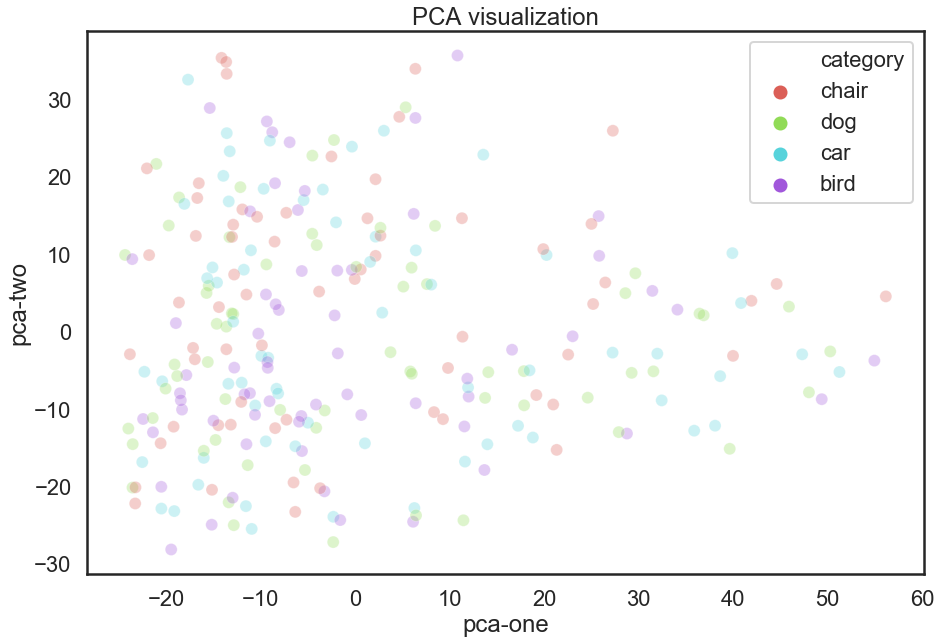

In [123]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=feats_df2,
    legend="full",
    alpha=0.3
).set_title('PCA visualization')

In [115]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats_df2[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.044s...
[t-SNE] Computed neighbors for 256 samples in 1.226s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 14.894630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.085297
[t-SNE] KL divergence after 300 iterations: 0.954136
t-SNE done! Time elapsed: 3.6292741298675537 seconds


Text(0.5, 1.0, 't-SNE visualization')

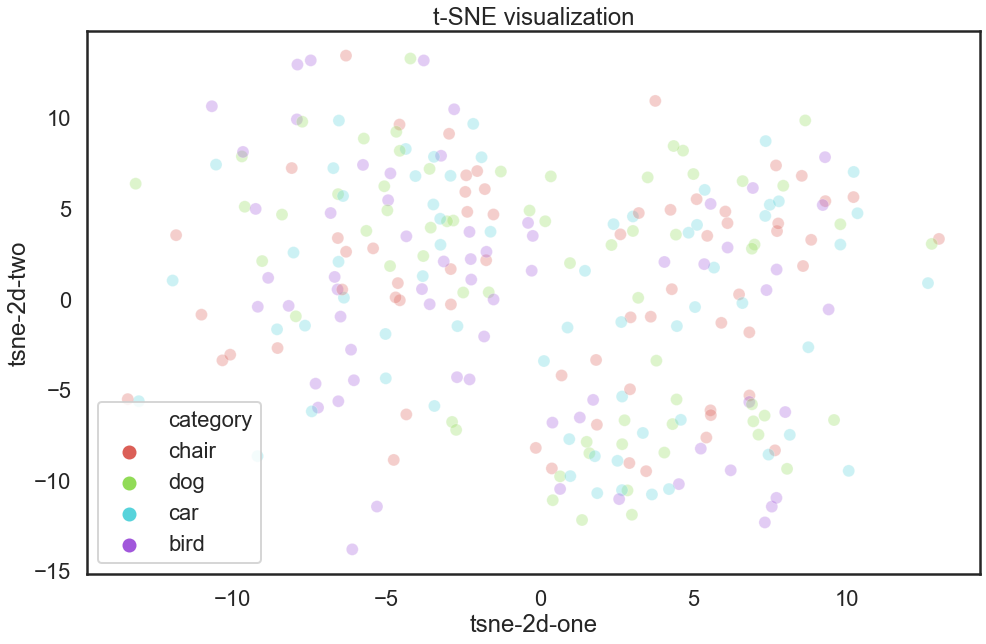

In [126]:
feats_df2['tsne-2d-one'] = tsne_results[:,0]
feats_df2['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=feats_df2,
    legend="full",
    alpha=0.3
).set_title('t-SNE visualization')